In [20]:
# Install required libraries
!pip install -q transformers datasets evaluate accelerate scikit-learn
# Fix the protobuf conflict
# !pip install protobuf==3.20.3

print("Libraries installed successfully.")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Libraries installed successfully.


In [21]:
import torch
import pandas as pd
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import (
    AlbertTokenizer,                  # ← Changed
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate
import numpy as np
import os
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
from transformers import EarlyStoppingCallback

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
login(token=hf_token)  # Paste your token

In [ ]:
# Load the full Dreaddit dataset from Hugging Face
# It has built-in train and test splits (~2,840 train, ~713 test)
# https://huggingface.co/datasets/asmaab/dreaddit
dataset = load_dataset("asmaab/dreaddit", split=None, revision="main")

print("Full dataset loaded:")
print("Train rows:", len(dataset["train"]))
print("Validation rows:", len(dataset["validation"]))
print("Test rows:", len(dataset["test"]))

Full dataset loaded:
Train rows: 2270
Validation rows: 568
Test rows: 715


In [ ]:
# Tokenizer
# https://huggingface.co/mental/mental-roberta-base
model_name = "mental/mental-roberta-base"  # Mental health specialized RoBERTa
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Rename label → labels
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
# Model (binary classification)
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Metrics (same as before)
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_macro = f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    f1_weighted = f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision_macro = precision.compute(predictions=predictions, references=labels, average="macro")["precision"]
    recall_macro = recall.compute(predictions=predictions, references=labels, average="macro")["recall"]
    
    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }


In [26]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./albert_stress_results",
    num_train_epochs=5,                  
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.1,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    fp16=True if torch.cuda.is_available() else False,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
)

In [27]:
# Trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.427300,0.387352,0.832746,0.826352,0.829402,0.849194,0.822068
2,0.354200,0.403373,0.811620,0.801375,0.805504,0.839700,0.797512
3,0.224600,0.464768,0.836268,0.832517,0.834811,0.841497,0.829520
4,0.104300,0.730359,0.823944,0.815133,0.818828,0.849800,0.810753
5,0.034900,0.751158,0.838028,0.836200,0.837784,0.837384,0.835359


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=355, training_loss=0.27172940852986255, metrics={'train_runtime': 246.5893, 'train_samples_per_second': 46.028, 'train_steps_per_second': 1.44, 'total_flos': 1240604598237000.0, 'train_loss': 0.27172940852986255, 'epoch': 5.0})

In [28]:
# Test evaluation and save
test_results = trainer.evaluate(tokenized_datasets["test"])
print("Final Test Results:", test_results)

trainer.save_model("./fine_tuned_albert_stress_model")
tokenizer.save_pretrained("./fine_tuned_albert_stress_model")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Final Test Results: {'eval_loss': 0.888090193271637, 'eval_accuracy': 0.8195804195804196, 'eval_f1_macro': 0.8181231994226321, 'eval_f1_weighted': 0.818646887916837, 'eval_precision_macro': 0.8242103158736506, 'eval_recall_macro': 0.8175470338518414, 'eval_runtime': 4.5395, 'eval_samples_per_second': 157.505, 'eval_steps_per_second': 5.067, 'epoch': 5.0}


('./fine_tuned_albert_stress_model/tokenizer_config.json',
 './fine_tuned_albert_stress_model/special_tokens_map.json',
 './fine_tuned_albert_stress_model/vocab.json',
 './fine_tuned_albert_stress_model/merges.txt',
 './fine_tuned_albert_stress_model/added_tokens.json',
 './fine_tuned_albert_stress_model/tokenizer.json')

In [29]:
import shutil
import os
from IPython.display import FileLink

# Define folder names
model_folder = "./fine_tuned_albert_stress_model" # This matches the trainer.save_model() path
output_filename = "stress_detection_mental_roberta"

# Compress the folder
print(f"Zipping model from {model_folder}...")
shutil.make_archive(output_filename, 'zip', model_folder)

# Create Download Link
print(f"✅ Ready! Click below to download:")
FileLink(f'{output_filename}.zip')

Zipping model from ./fine_tuned_albert_stress_model...
✅ Ready! Click below to download:


/kaggle/working/stress_detection_mental_roberta.zip

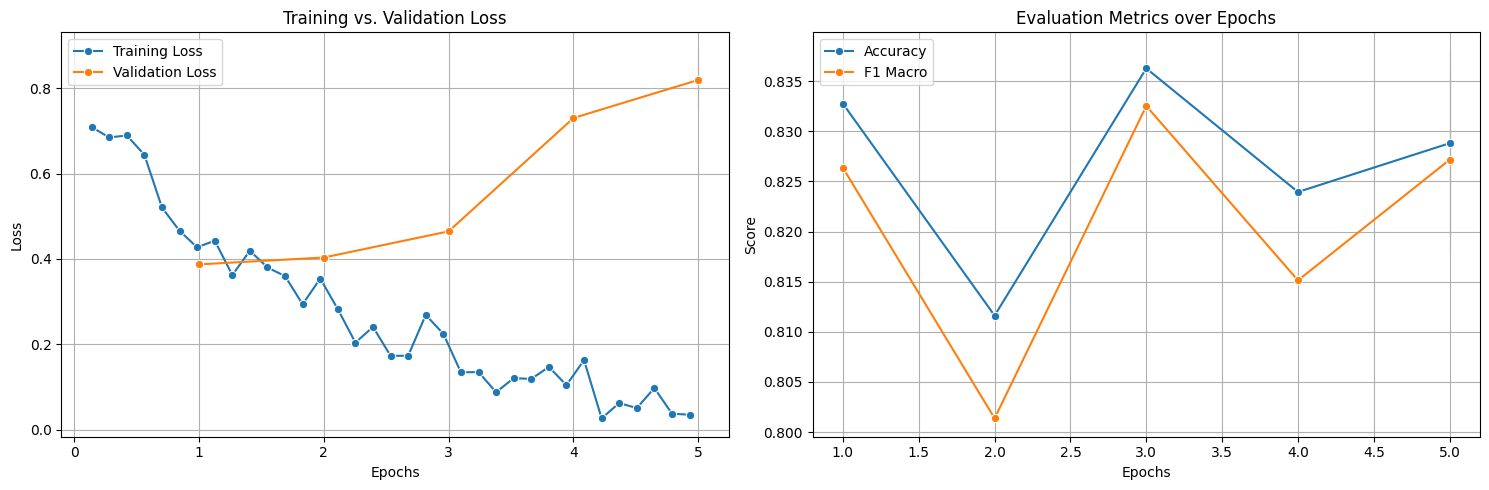

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Extract logs from the trainer
history = trainer.state.log_history

# Separate training and evaluation logs
train_logs = [x for x in history if 'loss' in x and 'epoch' in x]
eval_logs = [x for x in history if 'eval_loss' in x and 'epoch' in x]

# Create DataFrames
df_train = pd.DataFrame(train_logs)
df_eval = pd.DataFrame(eval_logs)

# 2. Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
sns.lineplot(ax=axes[0], x=df_train['epoch'], y=df_train['loss'], label='Training Loss', marker='o')
if not df_eval.empty:
    sns.lineplot(ax=axes[0], x=df_eval['epoch'], y=df_eval['eval_loss'], label='Validation Loss', marker='o')

axes[0].set_title('Training vs. Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Plot Metrics (Accuracy & F1)
if not df_eval.empty:
    sns.lineplot(ax=axes[1], x=df_eval['epoch'], y=df_eval['eval_accuracy'], label='Accuracy', marker='o')
    sns.lineplot(ax=axes[1], x=df_eval['epoch'], y=df_eval['eval_f1_macro'], label='F1 Macro', marker='o')
    
    axes[1].set_title('Evaluation Metrics over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Score')
    axes[1].grid(True)

plt.tight_layout()
plt.show()

Generating predictions for Validation...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

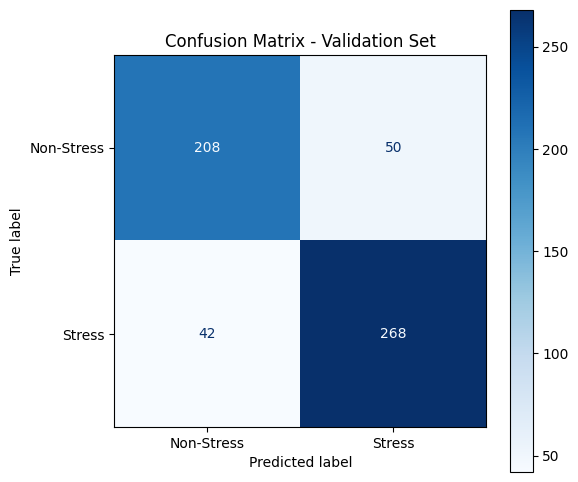

Generating predictions for Test...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

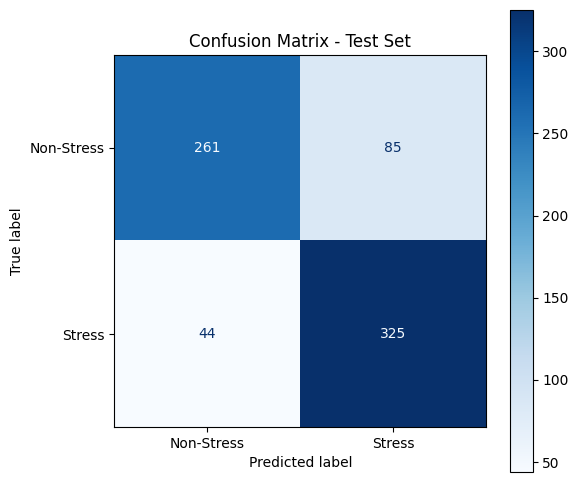

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(dataset, split_name):
    # Get predictions from the trainer
    print(f"Generating predictions for {split_name}...")
    predictions_output = trainer.predict(dataset)
    
    # Extract logits and convert to class IDs (0 or 1)
    preds = np.argmax(predictions_output.predictions, axis=-1)
    labels = predictions_output.label_ids
    
    # Calculate confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Stress", "Stress"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title(f'Confusion Matrix - {split_name} Set')
    plt.show()

# Plot for Validation Split (Checking for overfitting)
plot_confusion_matrix(tokenized_datasets["validation"], "Validation")

# Plot for Test Split (Final Performance)
plot_confusion_matrix(tokenized_datasets["test"], "Test")